## LSTM Model

In [46]:
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
from indicnlp.tokenize.sentence_tokenize import sentence_split

In [47]:
text = ''
with open('datasets/iit_bombay/dev_test/dev.hi', 'r') as file:
    text = file.read()
text

'महानगर पालिका अंतर्गत दत्तात्रय नगर माध्यमिक स्कूल के विद्यार्थियों ने काल्पनिक किला \'दत्तगढ़\' बनाकर अपनी कल्पनाशक्ति का परिचय दिया।\nप्रधानाध्यापक संध्या मेडपल्लीवार के प्रोत्साहित करने पर शिक्षकों व विद्यार्थियों ने मिट्टïी से किले का निर्माण किया।\nमनपा शिक्षक संघ के अध्यक्ष राजेश गवरे ने स्कूल को भेंट देकर सराहना की।\nकिले का परीक्षण रमेश सातपुते ने किया।\nकिला निर्माण में निखिल कावले, दर्शन गेड़ेकर, साहिल मेश्राम इन विद्यार्थियों ने सहभाग लिया।\nजिला कलाध्यापक संघ के अध्यक्ष नरेंद्र बारई, कोषाध्यक्ष शेखर वानस्कर, सदस्य अजय गुंडमवार, गजानन मेहर ने विद्यार्थियों का मार्गदर्शन किया।\nनगरसेवक रीता मुले ने सदिच्छा भेंट दी।\nरोहतक. नौकरियों में भ्रष्टाचार, फर्जीवाड़े व लूट- खसोट के खिलाफ अखिल भारतीय जनवादी महिला समिति और डीवाईएफआई ने संयुक्त रूप से प्रदेशव्यापी अभियान शुरू किया है।\nइस राज्यव्यापी हस्ताक्षर अभियान के माध्यम से प्रदेश भर में 10 लाख हस्ताक्षर करवाकर राज्यपाल को सौंपे जाएंगे।\nशुक्रवार को नए बस स्टैंड पर हस्ताक्षर अभियान की शुरुआत की गई।\nइस मौके पर एसएफआई के राज्य सचिव

In [48]:
text = text.split('\n')
_, test_text = train_test_split(text, train_size=0.7)
text = "\n".join(text)
test_text = "\n".join(test_text)

In [49]:
class LSTMModel:
    def _tokenize(self, text: str):
        sents = sentence_split(text, lang='hi')
        self.tok_sents = [trivial_tokenize(sent) for sent in sents]
        self.words = [word for sent in self.tok_sents for word in sent]
        self.vocabulary = list(set(self.words))
        self.vocab_len = len(self.vocabulary)
        self.vocabulary_index = {
            word: i for i, word in enumerate(self.vocabulary)
        }

    def __init__(self, text: str, word_len: int=5, epochs: int=5):
        self._tokenize(text)
        self.word_len = word_len
        # feature engineering?
        prev_words = []
        next_words = []
        for i in range(len(self.words) - self.word_len):
            prev_words.append(self.words[i:i + self.word_len])
            next_words.append(self.words[i + self.word_len])
        # storing features and labels?
        X = np.zeros((len(prev_words), self.word_len, self.vocab_len), dtype=bool)
        Y = np.zeros((len(next_words), self.vocab_len), dtype=bool)
        for i, each_words in enumerate(prev_words):
            for j, each_word in enumerate(each_words):
                X[i, j, self.vocabulary_index[each_word]] = 1
            Y[i, self.vocabulary_index[next_words[i]]] = 1
        # making the model
        self.model = Sequential()

        self.model.add(LSTM(128, input_shape=(self.word_len, self.vocab_len)))
        self.model.add(Dense(self.vocab_len))
        self.model.add(Activation('softmax'))

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=RMSprop(lr=0.01),
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            X, Y,
            validation_split=0.3,
            batch_size=128,
            epochs=epochs,
            shuffle=True
        ).history

    def _prepare_input(self, text):
        x = np.zeros((1, self.word_len, self.vocab_len))
        for t, word in enumerate(text.split()):
            x[0, t, self.vocabulary_index[word]] = 1
        return x
    
    def _sample(self, preds, top_n=3):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds)
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        return heapq.nlargest(top_n, range(len(preds)), preds.take)
    
    def getNextWord(self, text):
        x = self._prepare_input(text)
        preds = self.model.predict(x, verbose=0)[0]
        next_indices = self._sample(preds)
        return [self.vocabulary[ind] for ind in next_indices]

    # def generateText(self, )

In [50]:
model = LSTMModel(text, word_len=2, epochs=5)

Epoch 1/5


2023-04-08 17:33:22.162781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 17:33:22.166073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 17:33:22.167732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/56 [============================>.] - ETA: 0s - loss: 6.7607 - accuracy: 0.0580

2023-04-08 17:33:29.753417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 17:33:29.756343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 17:33:29.762079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

56/56 [==============================] - 8s 96ms/step - loss: 6.7623 - accuracy: 0.0580 - val_loss: 6.5833 - val_accuracy: 0.0915
Epoch 2/5
56/56 [==============================] - 5s 85ms/step - loss: 5.9411 - accuracy: 0.1047 - val_loss: 6.5578 - val_accuracy: 0.1136
Epoch 3/5
56/56 [==============================] - 5s 81ms/step - loss: 5.3348 - accuracy: 0.1580 - val_loss: 6.9405 - val_accuracy: 0.1113
Epoch 4/5
56/56 [==============================] - 5s 82ms/step - loss: 4.7059 - accuracy: 0.2269 - val_loss: 6.7030 - val_accuracy: 0.1066
Epoch 5/5
56/56 [==============================] - 5s 96ms/step - loss: 4.0906 - accuracy: 0.2974 - val_loss: 6.7639 - val_accuracy: 0.0987


In [51]:
model.getNextWord('यानि कि')

2023-04-08 17:33:50.292060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 17:33:50.294923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 17:33:50.296665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

['आवेदन', 'सचिव', 'लिए']

## Testing

In [52]:
test_sents = [trivial_tokenize(sent, lang="hi") for sent in sentence_split(test_text, lang="hi")]

In [61]:
testing_set = [sent[1:3] for sent in test_sents]
inpts = [" ".join(word[:-1]) for word in testing_set]
preds = [model.getNextWord(inp) for inp in inpts]
actuals = [word[-1] for word in testing_set]
acc = [1 if actual == pred else 0 for pred, actual in zip(preds, actuals)]
accuracy = sum(acc)/len(acc)
accuracy

0.63051282051282051

In [62]:
model.history

{'loss': [6.762287616729736,
  5.94108772277832,
  5.334796905517578,
  4.705850601196289,
  4.090631484985352],
 'accuracy': [0.0579853281378746,
  0.10468397289514542,
  0.15801353752613068,
  0.22686229646205902,
  0.29740405082702637],
 'val_loss': [6.583323955535889,
  6.557765007019043,
  6.940500259399414,
  6.703044414520264,
  6.7638654708862305],
 'val_accuracy': [0.09150756895542145,
  0.11356155574321747,
  0.111257404088974,
  0.10664910823106766,
  0.09874917566776276]}

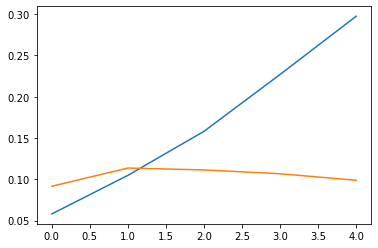

In [63]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.show()